In [26]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif']=['Microsoft Yahei']
plt.style.use("seaborn-talk")
%matplotlib inline

<div class="jumbotron">
    <h1 class="display-1">聚类技术</h1>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

<p class="h3">客户关系管理的目标是什么？</p>

- 有的放矢，生成可控的目标客户群

- 量体裁衣，制定有针对性的营销计划

- 识别战略焦点与业务发展方向

> 核心是将客户进行**分群**管理

- 例：电信客户营销

群组|群组特征|营销策略
---|---|---
1|深夜通话<br>多发短信<br>多与预付费客户通话<br>避免忙时通话|夜间通话套餐，短信礼包，转为预付费，激励通话量
2|多发短信<br>多与预付费用户通话<br>避免忙时通话|闲时通话套餐,短信礼包，激励通话量
3|高通话量<br>多与网外用户通话<br>有国际长途|激励国际长途电话，高端资费方案
4|交往圈固定<br>多与后付费用户通话|高价值客户礼包，业务引荐奖励
5|高通话量<br>多与网外用户通话|激励话音用量
6|固网通话多<br>高通话量<br>喜欢早晨通话|移动-固网通话套餐，晨间通话套餐
7|多发短信<br>忙时通话多|短信激励，忙时通话套餐
8|高通话量<br>喜欢深夜通话<br>闲时通话多|夜间通话套餐，闲时通话套餐


- 分组的目标：拥有相似特征的客户位于同一组内，而具有不同特征的客户分配在不同组

> 需要**聚类分析（clustering analysis）**技术

- 聚类分析的应用
    + 客户关系管理
    + 项目管理中实现对项目的分组管理
    + 网页搜索将返回的结果分成不同的类别
    + 医学中识别疾病之间的关联
    + 图像识别中识别不同的手写体
    + 识别异常点（outlier detection）

## 基本概念

### 聚类分析定义

<dl class="row alert-info">
    <dt class="col-md-2">聚类</dt>
    <dd class="col-md-10">是一种将特征相似的样本聚集到一起，从而达到区分具有不同特征样本的无监督算法</dd>
</dl>

- 不需要事先知道类别信息

- 聚类形成的每一个组，被称为**簇（cluster）**

- 聚类的目标：簇内的样本之间尽可能相似，不同簇的样本尽可能不同

<img src="./img/clustering/clustering.png" width=100%>

### 聚类类型

##### 划分聚类（paritional clustering）

- 将数据对象集划分成**不重叠**的子集（簇），使得每个数据对象**恰**在一个簇中

<img src="./img/clustering/partition.png" width=70%>

##### 层次聚类（hierarchical clustering）

- 嵌套簇的集族，形成一个树形结构

<img src="./img/clustering/hierarchical.png" width=70%>

- 树的每个节点（簇）都是子簇的**并**，而树根是包含所有对象的簇

### 聚类分析方法

- $K$均值（$K$-means）
    + 基于划分的聚类，发现指定个数（$K$）的簇
    + 样本之间的相似性通过**距离**反映
    + 簇之间彼此**互斥**，即每个样本**只能**分属于一个簇

- 层次聚类（hierarchical clustering）：对数据进行层次化（hierarchical）分解
    + 凝聚的层次聚类（agglomerative hierarchical clustering）：“自底向上”的方式，从每个样本开始逐步向上合并
    + 分裂的层次聚类（divisive hierarchical clustering）：“自顶向下”的方式，从所有样本属于一个初始簇开始，不断划分子簇

- 基于密度的方法（density-based methods）
    + 不同于$K$均值方法通过**距离**划分簇，通过**密度**划分簇
    + 只要某一个簇周边的数据点（样本点）密度超过阈值，就一直增加该簇

## K均值

- 基本思想：利用样本之间的距离衡量样本之间的相似性，用一组样本的质心centroid（该组样本的均值，适用于连续变量属性）作为簇的中心，找到紧凑且独立的簇
    - 如果属性是非连续变量，则一组样本中最有代表性的点或者出现频率最高的点作为质心，被称为medoid

### 基本算法

<center><img src='./img/clustering/kmago.svg' width=60%></center>

##### $K$均值聚类过程示例

<center><img src="./img/clustering/kmeansProcess.gif" width=100%></center>

#### 距离的度量

- 欧式空间：欧几里得距离，$n$维空间中两个点$\boldsymbol{x}$和$\boldsymbol{y}$之间的欧几里得距离是:
$$
d(\boldsymbol{x}, \boldsymbol{y}) = \sqrt{\sum_{k=1}^n(x_k-y_k)^2}
$$

#### 目标函数

> 通过设定**目标函数**，重新计算每个簇的质心

- 目标函数为每个点到最近质心的欧几里得距离的**误差平方和**（sum of the squared error, SSE）最小

$$
\begin{split}
SSE &= \sum_{i=1}^K\sum_{\boldsymbol{x}\in C_i}d(\boldsymbol{c}_i, \boldsymbol{x})^2\\
\boldsymbol{c}_i&=\frac{1}{m_i}\sum_{\boldsymbol{x}\in C_i}\boldsymbol{x}
\end{split}
$$
其中，$\boldsymbol{x}$是数据点，$C_i$是第$i$个簇，$c_i$是第$i$个簇的质心，$m_i$是第$i$个簇包含的数据点的个数，$K$是簇的个数

- 簇内的误差平方和（SSE）也被称作cluster inertia

#### 初始质心

- 随机选择$K$个样本作为初始质心

- 初始质心的选择对聚类结果有显著影响

<p class="h3">恰当的初始质心</p>
<center><img src="./img/clustering/kmeansProcess.gif" width=100%></center>

<p class="h3">错误的初始质心</p>
<center><img src="./img/clustering/kmeansInitialCentroid.gif" width=100%></center>

##### 改进初始质心的选择

<p class="h3">$K$-means++方法初始化质心</p>

- 顺次选择$k$个初始质心

- 主要思路
    + 1) 初始化一个空集合$\boldsymbol{M}$，存储$k$个质心
    + 2) 随机选择一个数据点（样本）作为第一个质心$\boldsymbol{\mu}_i$，放入$\boldsymbol{M}$
    + 3) 对于不在$M$中的任何一个样本$\boldsymbol{x}_j$，计算该样本到$M$中所有质心的距离的平方，选出其中最小的记为$d(\boldsymbol{x}_i,\boldsymbol{M})^2$
    + 4) 下一个质心点$\boldsymbol{\mu}_p$的选取概率为
    $$
    \frac{d(\boldsymbol{\mu}_p,\boldsymbol{M})^2}{\sum_{k=1}^Nd(\boldsymbol{x}_k,\boldsymbol{M})^2}
    $$
    + 5) 重复3）和4）步骤，直到选出$k$个初始质心

- 优势
    + 既保证了初始质心选择的随机性，同时又保证初始的质心分散较开

#### 离群点

> $K$均值聚类对离群点非常敏感

<p class="h3">例如，给定一组数据$\{1,2,3,8,9,10,25\}$，很容易观察到$\{1,2,3\}$属于一组，$\{8,9,10\}$属于一组，而25是离群点</p>

<p class="h3">应用$K$均值方法，假设$K=2$，</p>

- 如果划分成$\{1,2,3\}$和$\{8,9,10,25\}$两组，质心分别为2和13，则SSE（误差平方和）为

$$
    (1-2)^2+(2-2)^2+(3-2)^2+(8-13)^2+(9-13)^2+(10-13)^2+(25-13)^2=196
$$

- 如果划分成$\{1,2,3,8\}$和$\{9,10,25\}$两组，质心分别为3.5和14.67，则SSE（误差平方和）为

$$
    (1-3.5)^2+(2-3.5)^2+(3-3.5)^2+(8-3.5)^2+(9-14.67)^2+(10-14.67)^2+(25-14.67)^2=189.67
$$

- 由于第二种划分的SSE**小于**第一种划分，所以$K$均值方法会选择第二种结果

##### 如何消除离群点的影响

- 聚类之前剔除离群点

- 聚类过程中剔除离群点
    + 根据每个点对SSE的影响
    + 删除很小的簇，因为往往这些簇都是由离群点构成

### $K$均值的问题与改进

#### $K$均值的不足

- 当簇具有**不同大小**、**不同密度**、**非球形状**时，$K$均值方法很难检测到“自然的”簇

##### 不同大小

<img src="./img/clustering/size.png" width=100%>

##### 不同的密度

<img src="./img/clustering/density.png" width=80%>

##### 非球形状

<img src="./img/clustering/shape.png" width=80%>

#### 改进方法

> 初始用更多的簇，然后再将其合并

##### 不同大小

<img src="./img/clustering/sizesmall.png" width=80%>

##### 不同密度

<img src="./img/clustering/densitysmall.png" width=80%>

##### 非球形状

<img src="./img/clustering/shapesmall.png" width=80%>

### $K$均值的`Python`实现

```python
from sklearn.cluster import KMeans
KMeans(n_clusters=8, init=’k-means++’, max_iter=300, random_state=None)
```
- `n_clusters`：`int`类型，簇的个数
- `init`：初始质心的方法，可以选择`k-means++`或`random`
- `max_iter`：最大迭代次数
- `random_state`：初始质心的随机生成种子

#### 建立$K$均值聚类模型

##### 读取`iris`数据

In [4]:
irisdf = pd.read_csv('./data/visualization/iris.csv',header=0)
irisdf.head()
irisdf.shape

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


(150, 5)

##### 绘制属性箱型图，检查属性取值范围

<AxesSubplot:>

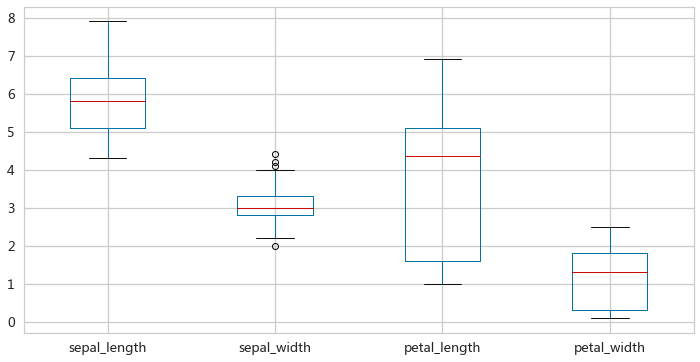

In [5]:
irisdf.plot(y=['sepal_length','sepal_width','petal_length','petal_width'],kind='box',figsize=(12,6))

- 各个属性取值基本可比，不需要进行标准化处理

##### 建立聚类模型

In [6]:
irisKmeans = KMeans(n_clusters=3,random_state=0)
irisKmeans

KMeans(n_clusters=3, random_state=0)

#### 训练$K$均值聚类模型

```python
kmeans.fit(X)
```
- `X`：需要聚类的数据集

In [7]:
irisX = irisdf.iloc[:,:-1]
irisX.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
irisKmeans.fit(irisX)

KMeans(n_clusters=3, random_state=0)

##### 训练好的聚类模型的属性

- `labels_`：每个数据点（样本）的标签，即所属的簇

In [9]:
irisKmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

- `inertia_`：簇内误差平方和

In [10]:
irisKmeans.inertia_

78.94084142614601

#### 预测样本所属的距离最近的簇

```python
kmean.predict(X)
```
- 返回值：每个样本属于的簇的标签，是一个数组结构，形状为`[n_samples]`

In [11]:
irisLabel = irisKmeans.predict(irisX)
irisLabel

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

#### 选择$K$值

> 随着$K$值的增大，簇内误差平方和（SSE）会降低

<dl class="row alert-info">
    <dt class="col-xl-4">肘部(elbow)法则<dt>
    <dd class="col-xl-8">识别SSE<strong>开始快速增大</strong>处的$K$值</dd>
</dl>

KMeans(n_clusters=1, random_state=0)

KMeans(n_clusters=2, random_state=0)

KMeans(n_clusters=3, random_state=0)

KMeans(n_clusters=4, random_state=0)

KMeans(n_clusters=5, random_state=0)

KMeans(n_clusters=6, random_state=0)

KMeans(n_clusters=7, random_state=0)

KMeans(random_state=0)

KMeans(n_clusters=9, random_state=0)

KMeans(n_clusters=10, random_state=0)

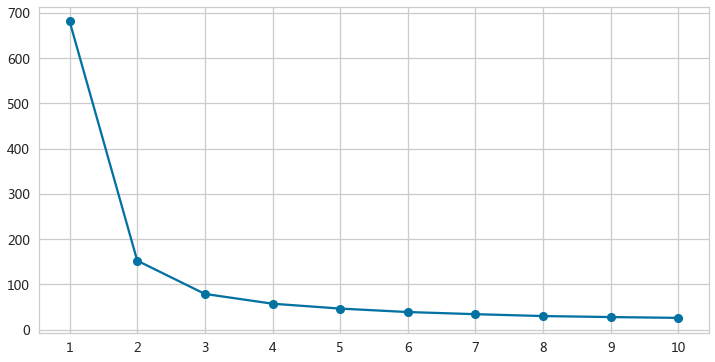

In [12]:
sse = []                ###记录每个k值对应的SSE
for each in range(1,11):
    km = KMeans(n_clusters=each,random_state=0)
    km.fit(irisX)
    sse.append(km.inertia_)
ax = pd.Series(sse).plot(kind='line',figsize=(12,6),marker='o',grid=True,xticks=range(0,10))   #xticks：在哪些位置显示x轴刻度标签
_ = ax.set(xticklabels=range(1,11))        # 改变x轴标签显示，默认是从0开始

- 当$K=3$的时候，SSE**开始快速增大**，所以选择3个簇

#### `scikit-learn`可视化package

- `Yellowbrick`：基于`scikit-learn`与`matplotlib`

```python
pip install -U yellowbrick
conda install -c districtdatalabs yellowbrick
```

- 绘制肘部图

```python
from yellowbrick.cluster import KElbowVisualizer
kviz = KElbowVisualizer(KMeans(), k=(1,11), metric='distortion', timings=True, locate_elbow=True)
kviz.fit(X)
kviz.show()
```
- `k`：需要检验的`k`值序列
- `metric`：检验的标准，默认是“距离误差平方和”，还可以是'silhouette`
- `timeings`：是否绘制计算每个`k`值对应的聚类时间
- `locate_elbow`：是否显示肘部位置

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

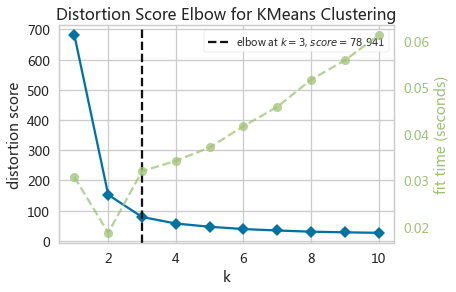

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
kmodel = KMeans(random_state=10)
elbowViz = KElbowVisualizer(kmodel, k=(1,11))
elbowViz.fit(irisX)
elbowViz.show()

## 凝聚层次聚类

<dl class="row alert-danger">
    <dt class="col-md-4">树状图（dendrogram）</dt>
    <dd class="col-md-8">显示簇——子簇联系，以及簇合并或分裂的次序</dd>
</dl>

<img src="./img/clustering/dendrogram.png" width=80%>

> 生成层次聚类的方法

- 凝聚的（agglomerative）
    + 从每个数据点（样本）作为个体簇开始，每一步合并两个最接近的簇

- 分裂的（divisive）
    + 从包含所有数据点（样本）的簇开始，每一步分裂一个簇，直到仅剩下单点簇

### 基本算法

<center><img src="./img/clustering/agglomerativeCluster.svg" width=60%></center>

#### 近邻度矩阵 

<dl class="row alert-danger">
    <dt class="col-xl-4">近邻度矩阵</dt>
    <dd class="col-xl-8">由两两簇之间的距离或相似度构成的矩阵</dd>
</dl>

<p class="h3">计算下列数据的近邻度矩阵，假设每个样本构成一个簇</p>

In [14]:
labels = [f'ID_{i}' for i in range(5)]
egDf = pd.DataFrame(np.random.random_sample([5,3])*10,columns=['X','Y','Z'],index=labels)
egDf

,X,Y,Z
ID_0,4.480831,7.411243,2.264558
ID_1,0.033672,1.459379,2.799354
ID_2,1.498592,6.696606,8.850473
ID_3,0.653278,9.797888,9.202516
ID_4,7.209125,0.548410,1.822219


In [15]:
from scipy.spatial.distance import pdist,squareform

```python
from scipy.spatial.distance import pdist,squareform
```
- `pdist(X, metric='euclidean')`：计算数据点两两之间的近邻度
    - `metric`：距离度量，可选'euclidean'，'mahalanobis','minkowski','cosine','jaccard'等
- `squareform(X)`：将距离数组转换成矩阵形式

In [16]:
pdist(egDf,metric='euclidean')

array([ 7.44902104,  7.26489669,  8.27535468,  7.39849427,  8.13575959,
       10.53162526,  7.29875188,  3.23364187, 10.94563102, 13.52777663])

In [17]:
rowDist = pd.DataFrame(squareform(pdist(egDf,metric='euclidean')),columns=labels,index=labels)
rowDist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,7.449021,7.264897,8.275355,7.398494
ID_1,7.449021,0.000000,8.135760,10.531625,7.298752
ID_2,7.264897,8.135760,0.000000,3.233642,10.945631
ID_3,8.275355,10.531625,3.233642,0.000000,13.527777
ID_4,7.398494,7.298752,10.945631,13.527777,0.000000


- 从近邻度矩阵中找到距离**最小**的两个簇，将其合并
- 计算合并的新簇与其他簇之间的距离，更新近邻度矩阵

#### 簇之间的近邻性度量

- 计算簇之间的距离
    + 单链接
    + 完全链接
    + 平均链接
    + Ward Linkage
    + Centroid Linkage

##### 单链接（single linkage）

- 簇间距离等于两个簇包含的数据点（样本）之间的**最小**距离

<center><img src="./img/clustering/min.png" width=60%></center>

##### 完全链接（complete linkage）

- 簇间距离等于两个簇包含数据点（样本）之间的**最大**距离

<center><img src="./img/clustering/max.png" width=60%></center>

##### 平均链接（average linkage）

- 簇间距离等于两个簇包含数据点（样本）之间的**平均**距离

<center><img src="./img/clustering/gpavg.png" width=60%></center>

##### Ward Linkage

- 计算两个簇之间的误差平方和（sum of square effor, SSE）
- 将SSE增量最小的作为新簇

<center><img src="./img/clustering/wardLinkage.png" width=80%></center>

- 最常用的距离度量：Euclidean
    - 低维数据
- 最常用的近邻性度量：Ward Linkage

### 层次聚类的不足

- 一旦两个簇合并之后，该过程不可逆

- 缺乏全局目标函数

### 凝聚层次聚类的`Python`实现

```python
from scipy.cluster import hierarchy
hierarchy.linkage(y, method='single', metric='euclidean')
```
- `y`：利用`pdist()`函数得到的两两样本之间的距离数组，或者是原始数据
- `method`：簇之间的近邻性度量方法，可取的值包括`single`，`complete`，`average`等
- `metric`：选用的距离
- 返回值：`linkage`矩阵，层次聚类的结果

#### 读取数据并预处理

In [18]:
cityDf = pd.read_csv('./data/clustering/cities_10.csv',header=0)
cityDf.head()

,AREA,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,Liaoning,5458.2,13000,1376.2,2258.4,1315.9,529.0,2258.4,123.7,399.7
1,Shandong,10550.0,11643,3502.5,3851.0,2288.7,1070.7,3181.9,211.1,610.2
2,Hebei,6076.6,9047,1406.7,2092.6,1161.6,597.1,1968.3,45.9,302.3
3,Tianjin,2022.6,22068,822.8,960.0,703.7,361.9,941.4,115.7,171.8
4,Jiangsu,10636.3,14397,3536.3,3967.2,2320.0,1141.3,3215.8,384.7,643.7


In [19]:
cityDf.set_index(cityDf.pop('AREA'),inplace=True)
cityDf

,X1,X2,X3,X4,X5,X6,X7,X8,X9
AREA,,,,,,,,,
Liaoning,5458.2,13000,1376.2,2258.4,1315.9,529.0,2258.4,123.7,399.7
Shandong,10550.0,11643,3502.5,3851.0,2288.7,1070.7,3181.9,211.1,610.2
Hebei,6076.6,9047,1406.7,2092.6,1161.6,597.1,1968.3,45.9,302.3
Tianjin,2022.6,22068,822.8,960.0,703.7,361.9,941.4,115.7,171.8
Jiangsu,10636.3,14397,3536.3,3967.2,2320.0,1141.3,3215.8,384.7,643.7
Shanghai,5408.8,40627,2196.2,2755.8,1970.2,779.3,2035.2,320.5,709.0
Zhejiang,7670.0,16570,2356.5,3065.0,2296.6,1180.6,2877.5,294.2,566.9
Fujian,4682.0,13510,1047.1,1859.0,964.5,397.9,1663.3,173.7,272.9
Guangdong,11769.7,15030,4224.6,4793.6,3022.9,1275.5,5013.6,1843.7,1201.6


##### 绘制属性的箱型图，展示各个属性的取值范围

<AxesSubplot:>

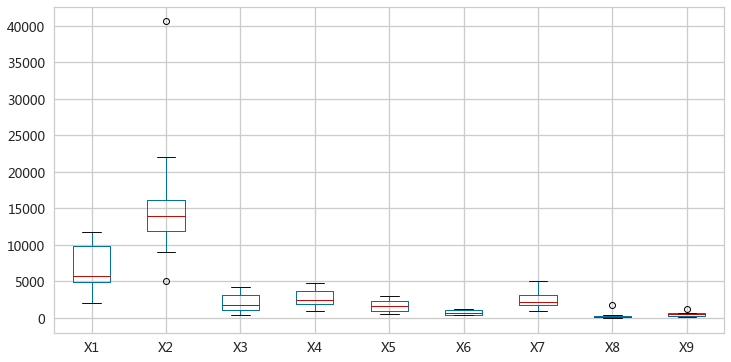

In [20]:
cityDf.plot(y=[f'X{i}' for i in range(1,10)],kind='box',figsize=(12,6))

- 各个属性取值范围差异较大，需要对数据进行标准化

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
cityScaler = StandardScaler()
cityX = cityScaler.fit_transform(cityDf)
cityX

array([[-0.37574772, -0.33589708, -0.57070001, -0.33180084, -0.4351153 ,
        -0.68608742, -0.13882664, -0.44958874, -0.36008526],
       [ 1.19924012, -0.48315182,  1.14473196,  0.98455823,  0.79990984,
         0.8650543 ,  0.66401891, -0.27809633,  0.34976628],
       [-0.18446517, -0.76485655, -0.54609356, -0.46884237, -0.63100796,
        -0.49108511, -0.39102534, -0.60224445, -0.68853914],
       [-1.43844228,  0.6481162 , -1.01716572, -1.40498973, -1.21233816,
        -1.16457327, -1.28376177, -0.46528598, -1.12861338],
       [ 1.2259343 , -0.18430174,  1.17200074,  1.08060301,  0.83964698,
         1.06721529,  0.6934899 ,  0.0625339 ,  0.46273553],
       [-0.39102805,  2.66204455,  0.09085021,  0.07932373,  0.3955559 ,
         0.03063913, -0.33286576, -0.06343649,  0.68294126],
       [ 0.3084029 ,  0.05150118,  0.22017521,  0.33489213,  0.80993934,
         1.17974966,  0.39938849, -0.11504119,  0.20374931],
       [-0.61584072, -0.28055447, -0.83620754, -0.66192379, -0

#### 建立凝聚层次模型

In [23]:
from scipy.cluster import hierarchy

In [24]:
cityAve = hierarchy.linkage(cityX,method='average',metric='euclidean')
cityAve

array([[ 1.        ,  4.        ,  0.52163185,  2.        ],
       [ 0.        ,  2.        ,  0.71496212,  2.        ],
       [ 7.        , 11.        ,  1.02790917,  3.        ],
       [ 6.        , 10.        ,  1.60180338,  3.        ],
       [ 3.        ,  9.        ,  1.91026168,  2.        ],
       [12.        , 14.        ,  2.18719558,  5.        ],
       [ 5.        , 13.        ,  3.6865092 ,  4.        ],
       [15.        , 16.        ,  4.35894698,  9.        ],
       [ 8.        , 17.        ,  6.58954454, 10.        ]])

In [64]:
[(each,idx) for idx,each in enumerate(cityDf.index)]
pd.DataFrame(cityAve,columns=['行号','行号','距离','簇中包含的样本数量'],index=[f'簇{i}' for i in range(cityAve.shape[0])])

[('Liaoning', 0),
 ('Shandong', 1),
 ('Hebei', 2),
 ('Tianjin', 3),
 ('Jiangsu', 4),
 ('Shanghai', 5),
 ('Zhejiang', 6),
 ('Fujian', 7),
 ('Guangdong', 8),
 ('Guangxi', 9)]

,行号,行号,距离,簇中包含的样本数量
簇0,1.0,4.0,0.521632,2.0
簇1,0.0,2.0,0.714962,2.0
簇2,7.0,11.0,1.027909,3.0
簇3,6.0,10.0,1.601803,3.0
簇4,3.0,9.0,1.910262,2.0
簇5,12.0,14.0,2.187196,5.0
簇6,5.0,13.0,3.686509,4.0
簇7,15.0,16.0,4.358947,9.0
簇8,8.0,17.0,6.589545,10.0


#### 树状图展示

```python
from scipy.cluster import hierarchy
hierarchy.dendrogram(Z, orientation='top', labels=None, ax=None)
```
- `Z`：`linkage`矩阵，层次聚类结果
- `orientation`：根结点的位置，可选`{"top", "bottom","left","right"}
- `labels`：原始数据点的标签，默认为`None`，即原始数据样本默认的行标签
- `ax`：`matplotlib Axes`对象

In [26]:
import matplotlib.pyplot as plt 

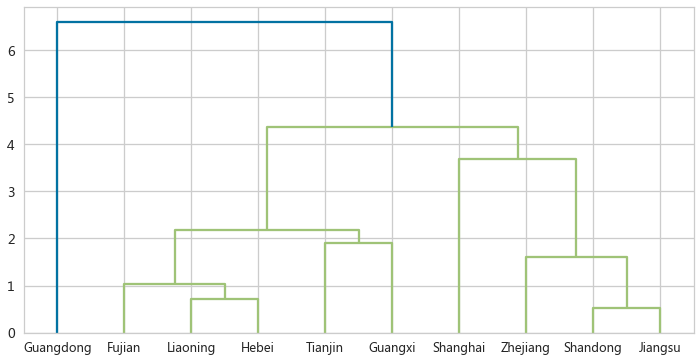

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
cityDn = hierarchy.dendrogram(cityAve,ax=ax,labels=cityDf.index)
plt.show()

#### `sklearn`中的凝聚层次聚类

```python
from sklearn.cluster import AgglomerativeClustering
AgglomerativeClustering(n_clusters=2, affinity=’euclidean’, linkage=’ward’)
```
- `n_clusters`：`int`类型，簇的个数
- `affinity`：近邻度的度量，可以选择`'euclidean', 'manhattan', 'cosine'`等
- `linkage`：`str`类型，簇之间的链接类型，可以选择`'ward', 'complete', 'average', 'single'`

> 利用`AgglomerativeClustering`对凝聚层次聚类剪枝

##### 建立凝聚层次模型

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
cityAc = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='average')
cityAc

AgglomerativeClustering(linkage='average', n_clusters=4)

##### 训练模型并预测样本所属的簇

In [31]:
cityLabels = cityAc.fit_predict(cityX)
cityLabels

array([0, 2, 0, 0, 2, 3, 2, 0, 1, 0])

In [32]:
cityDf['cluster']=cityLabels
cityDf

,X1,X2,X3,X4,X5,X6,X7,X8,X9,cluster
AREA,,,,,,,,,,
Liaoning,5458.2,13000,1376.2,2258.4,1315.9,529.0,2258.4,123.7,399.7,0
Shandong,10550.0,11643,3502.5,3851.0,2288.7,1070.7,3181.9,211.1,610.2,2
Hebei,6076.6,9047,1406.7,2092.6,1161.6,597.1,1968.3,45.9,302.3,0
Tianjin,2022.6,22068,822.8,960.0,703.7,361.9,941.4,115.7,171.8,0
Jiangsu,10636.3,14397,3536.3,3967.2,2320.0,1141.3,3215.8,384.7,643.7,2
Shanghai,5408.8,40627,2196.2,2755.8,1970.2,779.3,2035.2,320.5,709.0,3
Zhejiang,7670.0,16570,2356.5,3065.0,2296.6,1180.6,2877.5,294.2,566.9,2
Fujian,4682.0,13510,1047.1,1859.0,964.5,397.9,1663.3,173.7,272.9,0
Guangdong,11769.7,15030,4224.6,4793.6,3022.9,1275.5,5013.6,1843.7,1201.6,1


## 聚类检验

<dl class="row alert-info">
    <dt class="col-md-4">聚类检验</dt>
    <dd class="col-md-8">检验聚类效果的优劣</dd>
</dl>

- 评估指标
    + 监督评估，利用外部信息（例如类别）来判断聚类效果的优劣
    + 非监督评估：利用数据本身的信息来判断

### 非监督评估

<dl class="row alert-info">
    <dt class="col-lg-4">凝聚度(cohesion)</dt>
    <dd class="col-lg-8">簇内数据点之间的密切程度</dd>
</dl>

- 可以是簇内各个数据点之间距离的均值

<dl class="row alert-danger">
    <dt class="col-lg-4">分离度(separation)</dt>
    <dd class="col-lg-8">某个簇不同于其他簇的程度</dd>
</dl>

- 不同簇的数据点之间的距离的均值

<center><img src="./img/clustering/cohesionSeparation.png" width=60%></center>

### 轮廓系数（silhouette coefficient）

<center><img src="./img/clustering/silhouette.png" width=40%></center>

- $a_i$是第$i$个数据对象到所属簇中其他所有数据对象距离的平均值

- 计算第$i$个数据对象到给定簇(**非所属簇**)中所有数据对象距离的平均值
- 所有$K-1$（$K$为簇的数量）个这样的值中的最小值定义为$b_i$

$$
s_i = \frac{b_i-a_i}{\max(a_i,b_i)}
$$

$s_i\in[-1,1]$

- 轮廓系数越接近1越好
- 0表示两个簇重合
- -1表示数据点被分配到了错误的簇中

#### `Python`实现

```python
from sklearn.metrics import silouette_samples, silhouette_score
```

```python
silhouette_samples(X, labels, metric=’euclidean’)
```
- `X`：用于聚类的数据
- `labels`：用聚类技术计算的每个数据样本所属的簇
- 返回值：由所有样本的轮廓系数构成的数据，形状为`[n_samples]`

```python
silhouette_score(X, labels, metric=’euclidean’)
```
- `X`：用于聚类的数据
- `labels`：用聚类技术计算的每个数据样本所属的簇
- 返回值：`float`类型，所有数据样本的轮廓系数的平均值

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [37]:
irisSilhouetteVals = silhouette_samples(irisX,irisKmeans.labels_)
irisSilhouetteVals

array([0.85157298, 0.817887  , 0.83008729, 0.8065908 , 0.84699565,
       0.74628444, 0.8210796 , 0.85340748, 0.75384818, 0.82895302,
       0.80150542, 0.83563957, 0.81325176, 0.74707696, 0.70091086,
       0.64149392, 0.77354754, 0.84964579, 0.70548523, 0.8178354 ,
       0.78413148, 0.8237893 , 0.79157875, 0.79422255, 0.77521625,
       0.80130908, 0.8329435 , 0.84096492, 0.84314169, 0.81915866,
       0.81735915, 0.79854746, 0.76017812, 0.71993736, 0.82895302,
       0.83285788, 0.79335138, 0.82895302, 0.7698255 , 0.84989778,
       0.84788216, 0.6413782 , 0.78707116, 0.7991425 , 0.74523195,
       0.81162359, 0.81106264, 0.8198735 , 0.81643527, 0.85237895,
       0.02672203, 0.38118643, 0.05340075, 0.59294381, 0.36885321,
       0.59221025, 0.28232583, 0.26365142, 0.34419223, 0.57829491,
       0.3733641 , 0.58710354, 0.55107857, 0.48216686, 0.56268236,
       0.32459291, 0.55751057, 0.61072967, 0.46149897, 0.6115753 ,
       0.32909528, 0.58968904, 0.31046301, 0.49424779, 0.50004

In [38]:
irisSilhouetteScore = silhouette_score(irisdf.iloc[:,:-1],irisKmeans.labels_)
irisSilhouetteScore

0.5525919445499757

- `silhouette_score`实际上等于`silhouette_samples`返回值的**均值**

In [39]:
irisSilhouetteVals.mean()

0.5525919445499757

#### 轮廓系数图

- 将每个簇中的样本的轮廓系数按升序排序，绘制成的水平柱状图

<center><img src="./img/clustering/silhouettePlot1.svg" width=60%></center>

- 好的聚类，轮廓系数图应当满足**各个簇的长度和宽度近似相等**

- `Yellowbrick`中的轮廓系数图

```python
from yellowbrick.cluster import SilhouetteVisualizer
silviz = SilhouetteVisualizer(estimator, colors=None)
silviz.fit(X)
silviz.show()
```
- `estimator`：聚类模型
- `color`：轮廓图颜色，可以是`Yellowbrick`或者`matplotlib`的颜色地图，例如`Yellowbrick`的颜色地图参考，[https://www.scikit-yb.org/en/latest/api/palettes.html](https://www.scikit-yb.org/en/latest/api/palettes.html)

SilhouetteVisualizer(ax=<AxesSubplot:>,
                     estimator=KMeans(n_clusters=3, random_state=0))

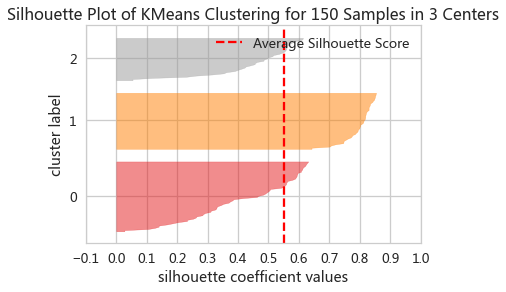

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 150 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
silViz = SilhouetteVisualizer(i ,color='yellowbrick')
silViz.fit(irisX)
silViz.show()

### 聚类结果可视化

- 将高维空间数据投射到低维（2维或3维）空间

- 核心需要在低维空间保持高维空间中点之间的相似关系

- 两种常用实现方法
    - MDS：Multi-Dimensional Scaling
    - t-SNE: t-Distributed Stochastic Neighbor Embedding 

##### MDS

- 在低维空间尽可能保持高维空间中点之间的距离

##### t-SNE

- 构建高维空间中点之间的概率分布，高斯分布
- 构建低维空间中点之间的概率分布，t分布
- 尽可能使得两个分布接近

##### 可视化方法

In [116]:
from yellowbrick.cluster import InterclusterDistance

```python
InterclusterDistance(estimator,embedding='mds',scoring='membership',random_state=None)
```
    - `estimator`：`scikit-learn`的聚类模型
    - `embedding`：高维空间到低维空间的投射方法，可以选择'mds'或'tsne'
    - `scoring`：决定簇在图上展现的大小，'membership'计算每个簇中样本数量

InterclusterDistance(ax=<AxesSubplot:>,
                     estimator=KMeans(n_clusters=3, random_state=0),
                     random_state=10)

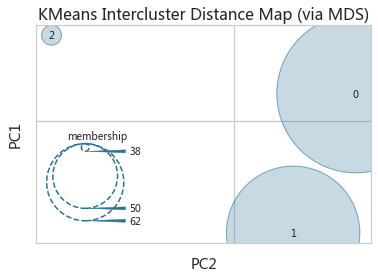

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [129]:
idVis = InterclusterDistance(irisKmeans,emdding='tsne',random_state=10)
idVis.fit(irisX)
idVis.show()

## 网站运营分析示例

<p class="h3">某企业由于投放的广告渠道比较多，需要对其做广告效果分析以实现有针对性的广告效果测量和优化工作。要求：将广告分类并找出重点特征，为后续的业务讨论提供支持。</p>

### 读入数据

In [4]:
adRaw = pd.read_csv('./data/clustering/ad_performance.txt',sep='\t')
adRaw.head()
adRaw.shape
adRaw.dtypes

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10.0,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30.0,jpg,banner,cpc,140*40,满减


(889, 13)

渠道代号       object
日均UV      float64
平均注册率     float64
平均搜索量     float64
访问深度      float64
平均停留时间    float64
订单转化率     float64
投放总时间     float64
素材类型       object
广告类型       object
合作方式       object
广告尺寸       object
广告卖点       object
dtype: object

### 数据探索

#### 描述性统计

In [5]:
adRaw.describe()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000000,889.000000,889.000000,889.000000,887.000000,889.000000,889.000000
mean,540.846772,0.001408,0.030493,2.167166,262.669188,0.002852,16.052868
std,1634.410463,0.003291,0.106199,3.800528,224.364932,0.011608,8.509435
min,0.060000,0.000000,0.000000,1.000000,1.640000,0.000000,1.000000
25%,6.180000,0.000000,0.000600,1.392300,126.020000,0.000000,9.000000
50%,114.180000,0.000000,0.003200,1.793100,236.550000,0.000200,16.000000
75%,466.870000,0.001400,0.011800,2.216200,357.985000,0.002000,24.000000
max,25294.770000,0.039100,1.037000,98.979900,4450.830000,0.216500,30.000000


- 发现
    + `平均停留时间`有2个缺失值
    + `日均UV`的波动性非常大（`std`值大）

In [6]:
for colName in adRaw.columns[-5:]:
    adRaw[colName].value_counts(normalize=True)

jpg    0.602925
swf    0.391451
gif    0.004499
sp     0.001125
Name: 素材类型, dtype: float64

不确定       0.735658
banner    0.172103
tips      0.060742
通栏        0.021372
横幅        0.008999
暂停        0.001125
Name: 广告类型, dtype: float64

cpc    0.665917
roi    0.274466
cpd    0.033746
cpm    0.025872
Name: 合作方式, dtype: float64

600*90     0.725534
308*388    0.116985
450*300    0.060742
140*40     0.055118
900*120    0.021372
480*360    0.010124
960*126    0.008999
390*270    0.001125
Name: 广告尺寸, dtype: float64

打折    0.379078
满减    0.194601
直降    0.190101
秒杀    0.085489
满返    0.078740
满赠    0.071991
Name: 广告卖点, dtype: float64

#### 数据可视化

##### 属性的分布特征

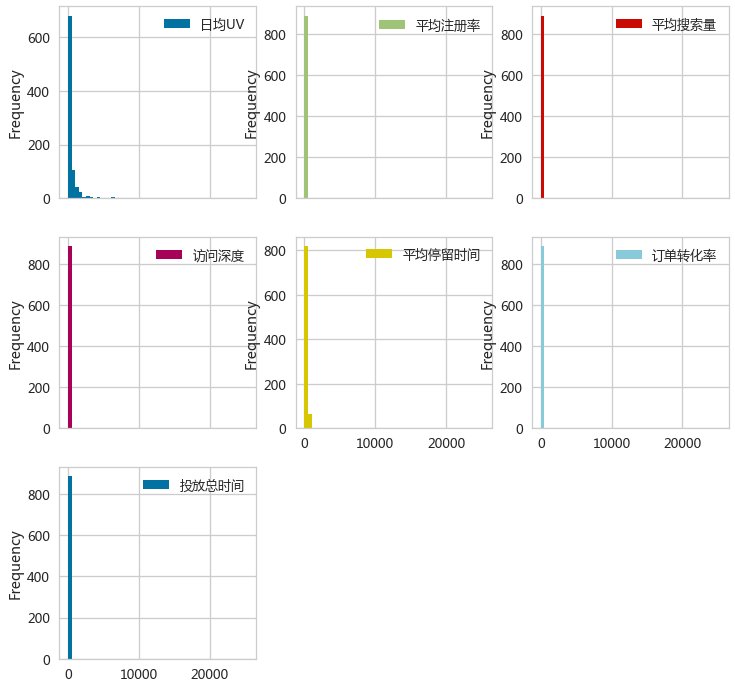

In [7]:
_ = adRaw.plot(y=['日均UV','平均注册率','平均搜索量','访问深度','平均停留时间','订单转化率','投放总时间'],kind='hist',bins=50,figsize=(12,12),subplots=True,layout=(3,3),sharey=False)

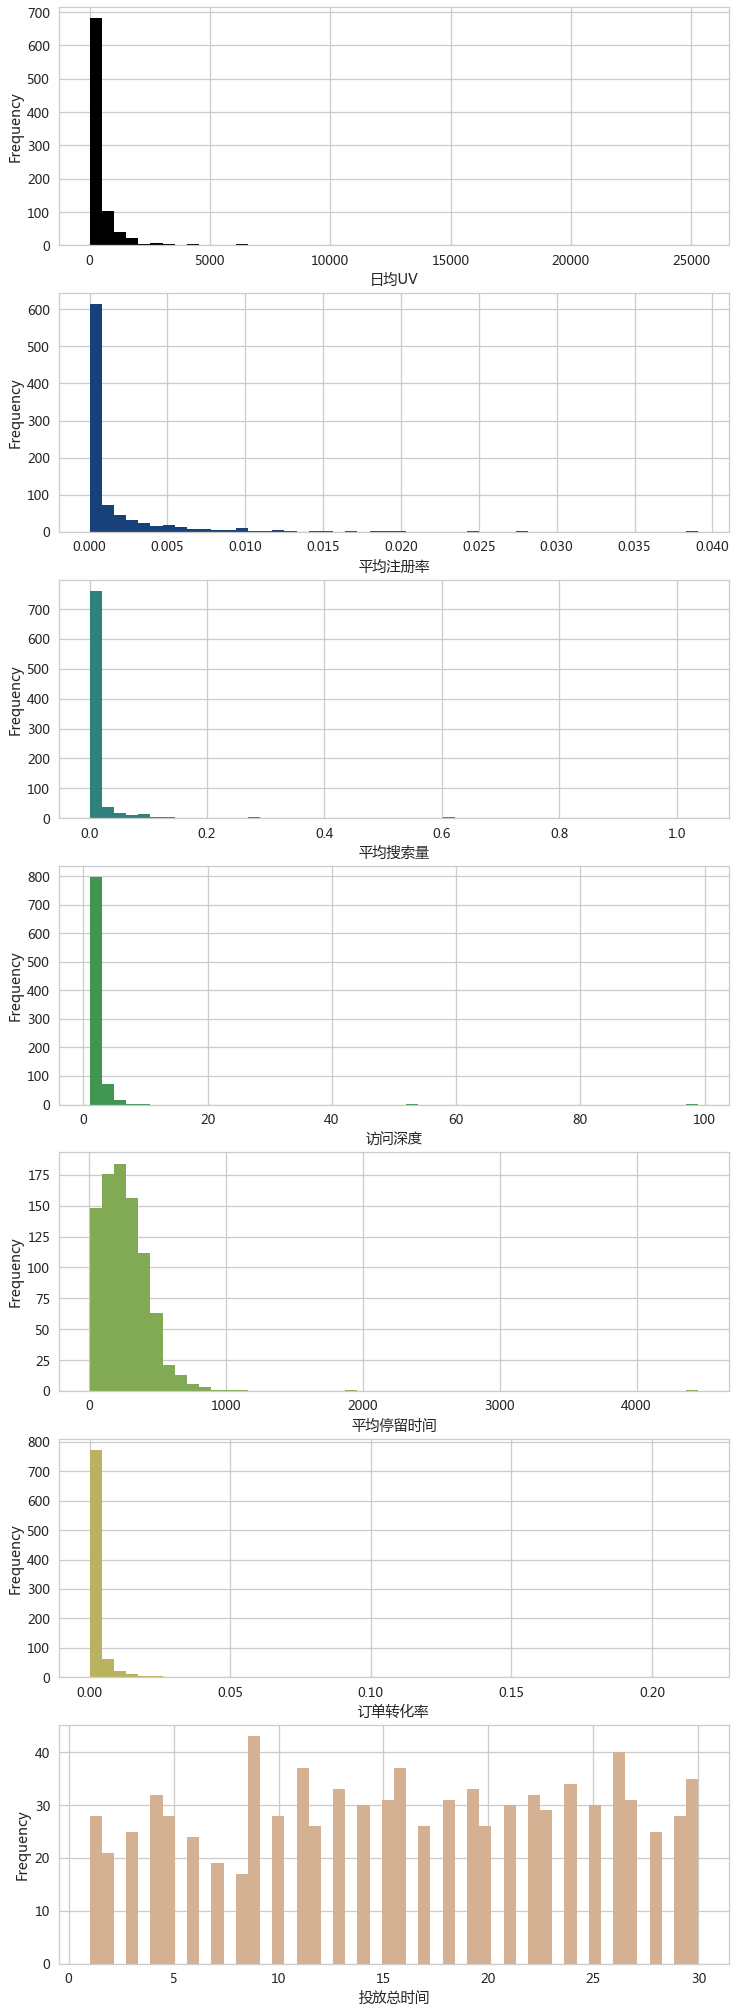

In [12]:
colNames = ['日均UV','平均注册率','平均搜索量','访问深度','平均停留时间','订单转化率','投放总时间']
fig,axes = plt.subplots(len(colNames),1,figsize=(12,36))
for i,colName in enumerate(colNames):
    _ = adRaw[colName].plot(y=colName,kind='hist',bins=50,ax=axes[i],color=cm.gist_earth(i/len(colNames)))
    _ = axes[i].set(xlabel=colName)

- 发现
    + `日均UV`,`平均注册率`,`平均搜索量`,`访问深度`,`平均停留时间`,`订单转化率`均呈现偏态分布

##### 属性的波动范围特征

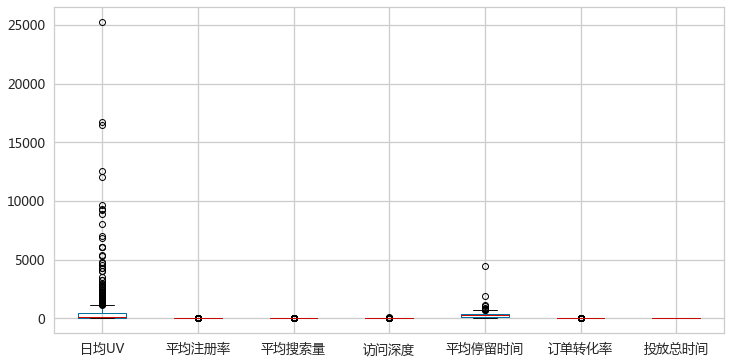

In [13]:
_ = adRaw.plot(y=colNames,kind='box',figsize=(12,6))

- 发现
    + 各个属性的波动范围差异较大
    + `日均UV`有较多的异常点

### 数据预处理

#### 缺失值

In [14]:
adRaw.isna().sum()

渠道代号      0
日均UV      0
平均注册率     0
平均搜索量     0
访问深度      0
平均停留时间    2
订单转化率     0
投放总时间     0
素材类型      0
广告类型      0
合作方式      0
广告尺寸      0
广告卖点      0
dtype: int64

##### 筛选含有缺失值的记录

In [15]:
adRaw.loc[adRaw['平均停留时间'].isna(),:]

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
498,A347,1.53,0.0,0.0,1.0,NaN,0.0,26.0,swf,不确定,roi,600*90,满减
528,A377,0.75,0.0,0.0,1.0,NaN,0.0,20.0,swf,不确定,roi,600*90,满减


##### 用均值填充缺失值

In [16]:
adRaw.fillna({'平均停留时间':adRaw['平均停留时间'].mean()},inplace=True)
adRaw.isna().sum()

渠道代号      0
日均UV      0
平均注册率     0
平均搜索量     0
访问深度      0
平均停留时间    0
订单转化率     0
投放总时间     0
素材类型      0
广告类型      0
合作方式      0
广告尺寸      0
广告卖点      0
dtype: int64

#### 重复记录

In [17]:
adRaw.duplicated().unique()

array([False])

- 不含有重复记录

#### 标称属性转换为数值型

In [18]:
adX = adRaw.copy()
for colName in adRaw.columns[-5:]:
    codes,_ = pd.factorize(adX[colName])
    adX[colName] = codes
adX.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,0,0,0,0,0
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,0,0,1,0,1
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,0,0,1,0,1
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10.0,0,0,1,0,1
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30.0,0,0,1,0,1


In [19]:
adX.set_index(keys='渠道代号',inplace=True)
adX.head()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
渠道代号,,,,,,,,,,,,
A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,0,0,0,0,0
A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,0,0,1,0,1
A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,0,0,1,0,1
A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10.0,0,0,1,0,1
A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30.0,0,0,1,0,1


#### 标准化数据

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
adScale = MinMaxScaler()
scaleDat = adScale.fit_transform(adX.iloc[:,:7])
scaleDf = pd.DataFrame(scaleDat,columns = adX.columns[:7],index=adX.index)
scaleDf.head()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
渠道代号,,,,,,,
A203,0.000144,0.181586,0.020636,0.013340,0.093979,0.119169,0.655172
A387,0.007062,0.102302,0.031244,0.010705,0.035130,0.013857,0.620690
A388,0.003626,0.056266,0.051109,0.008952,0.080080,0.012009,0.103448
A389,0.000041,0.189258,0.326133,0.033095,0.081460,0.070670,0.310345
A390,0.000131,0.071611,0.167792,0.012180,0.070058,0.003233,1.000000


In [22]:
adXScale = scaleDf.merge(right=adX.iloc[:,-5:],left_index=True,right_index=True)
adXScale.head()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
渠道代号,,,,,,,,,,,,
A203,0.000144,0.181586,0.020636,0.013340,0.093979,0.119169,0.655172,0,0,0,0,0
A387,0.007062,0.102302,0.031244,0.010705,0.035130,0.013857,0.620690,0,0,1,0,1
A388,0.003626,0.056266,0.051109,0.008952,0.080080,0.012009,0.103448,0,0,1,0,1
A389,0.000041,0.189258,0.326133,0.033095,0.081460,0.070670,0.310345,0,0,1,0,1
A390,0.000131,0.071611,0.167792,0.012180,0.070058,0.003233,1.000000,0,0,1,0,1


In [23]:
adXScale = scaleDf.merge(right=adX.iloc[:,7:],left_index=True,right_index=True)
adXScale.head()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
渠道代号,,,,,,,,,,,,
A203,0.000144,0.181586,0.020636,0.013340,0.093979,0.119169,0.655172,0,0,0,0,0
A387,0.007062,0.102302,0.031244,0.010705,0.035130,0.013857,0.620690,0,0,1,0,1
A388,0.003626,0.056266,0.051109,0.008952,0.080080,0.012009,0.103448,0,0,1,0,1
A389,0.000041,0.189258,0.326133,0.033095,0.081460,0.070670,0.310345,0,0,1,0,1
A390,0.000131,0.071611,0.167792,0.012180,0.070058,0.003233,1.000000,0,0,1,0,1


### $K$均值聚类

#### 选择$K$值

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

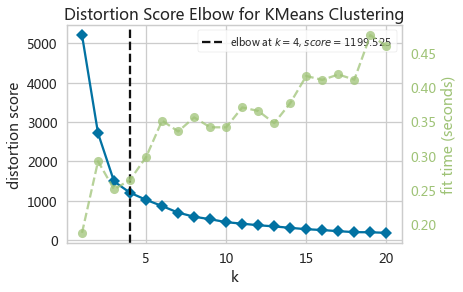

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
kwebElbowViz = KElbowVisualizer(KMeans(random_state=10),k=(1,21))
kwebElbowViz.fit(adXScale)
kwebElbowViz.show()

- 选择$K=4$

#### 建立并训练$K$均值模型

In [90]:
adKm = KMeans(n_clusters=4,random_state=20)
adClusters = adKm.fit_predict(adXScale)

In [91]:
pd.Series(adClusters).value_counts()

1    411
0    297
2    154
3     27
dtype: int64

#### 评估聚类效果

##### 轮廓系数均值

In [92]:
silhouette_score(X=adXScale,labels=adClusters)

0.5696854692292721

##### 轮廓系数图

SilhouetteVisualizer(ax=<AxesSubplot:>,
                     estimator=KMeans(n_clusters=4, random_state=20))

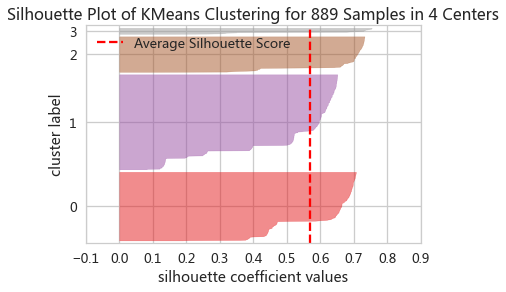

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 889 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [93]:
webSilViz = SilhouetteVisualizer(adKm,color='yellowbrick')
webSilViz.fit(adXScale)
webSilViz.show()

##### 簇的可视化

InterclusterDistance(ax=<AxesSubplot:>, embedding='tsne',
                     estimator=KMeans(n_clusters=4, random_state=20),
                     random_state=10)

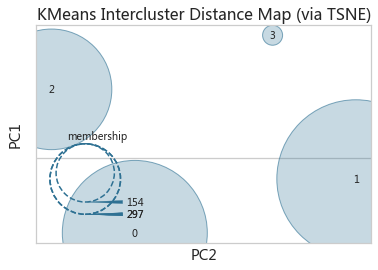

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via TSNE)'}, xlabel='PC2', ylabel='PC1'>

In [132]:
adKmIcVis = InterclusterDistance(adKm,embedding='tsne',random_state=10)
adKmIcVis.fit(adXScale)
adKmIcVis.show()

### 凝聚层次聚类

#### 建立凝聚层次模型

```python
from scipy.cluster import hierarchy
```

In [27]:
adLinkage = hierarchy.linkage(adXScale,method='average')

#### 绘制层次聚类树状图

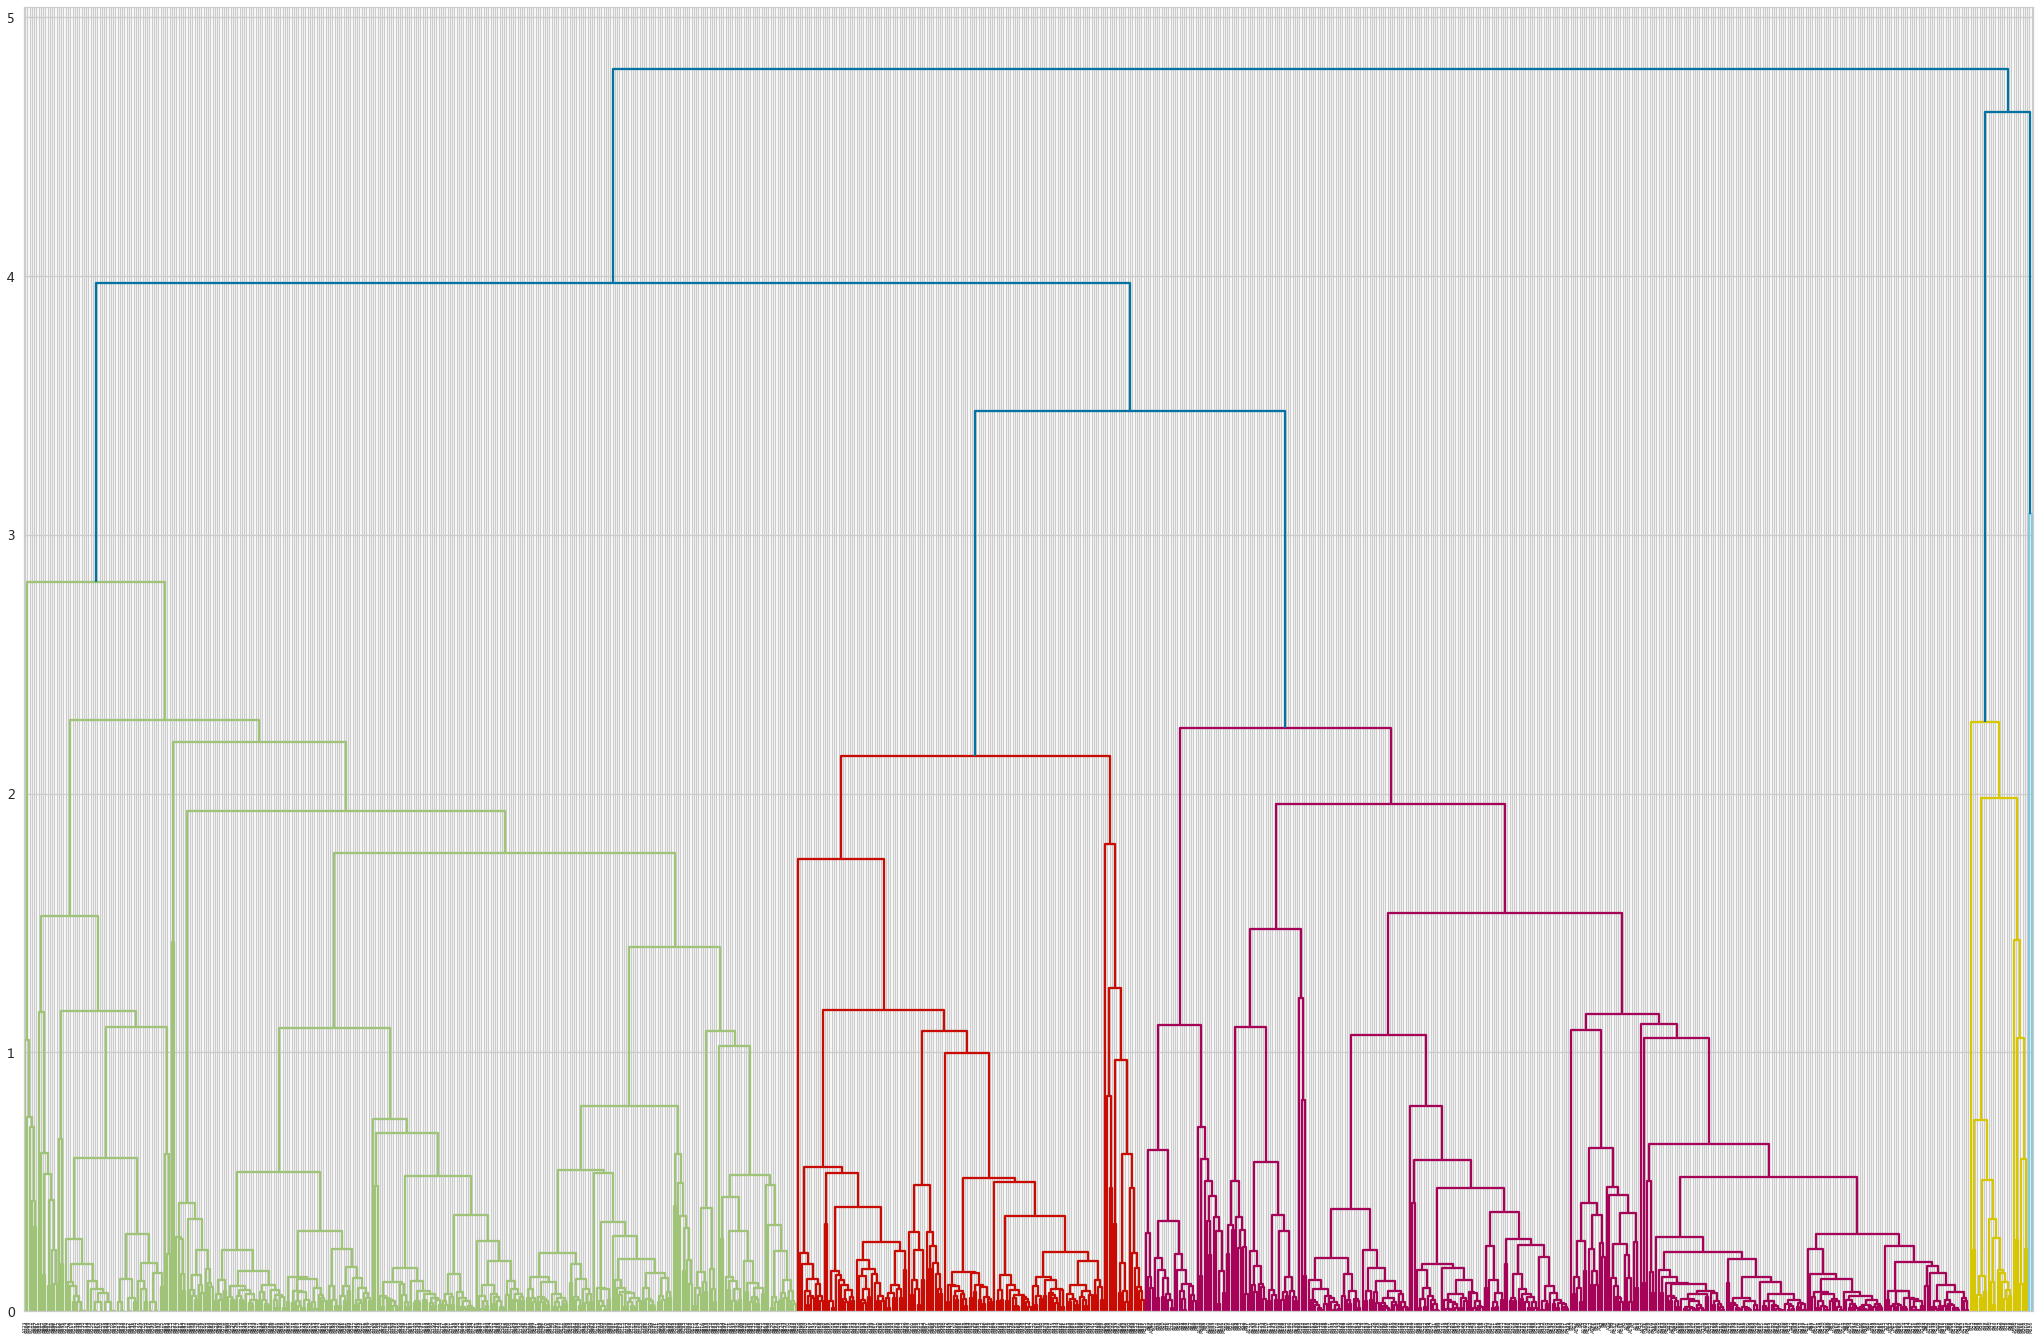

In [96]:
fig,axe = plt.subplots(figsize=(36,24))
_ = hierarchy.dendrogram(adLinkage,ax=axe,labels=adX.index)

#### 建立指定簇个数的凝聚层次模型

In [36]:
adHierarchy = AgglomerativeClustering(n_clusters=5,linkage='average')
adHierarchyClusters = adHierarchy.fit_predict(adXScale)

#### 检验聚类效果

In [37]:
silhouette_score(adXScale,adHierarchyClusters)

0.5695658078190916

### 簇特征分析

In [109]:
adDf = adRaw.copy()
adDf.set_index('渠道代号',inplace=True)

- 选用$K$均值聚类得到的4簇

#### 将簇标签增加到原数据集上

In [110]:
adDf['cluster'] = adClusters
adDf.head()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,cluster
渠道代号,,,,,,,,,,,,,
A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,jpg,banner,roi,140*40,打折,2
A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,jpg,banner,cpc,140*40,满减,2
A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,jpg,banner,cpc,140*40,满减,2
A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10.0,jpg,banner,cpc,140*40,满减,2
A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30.0,jpg,banner,cpc,140*40,满减,2


#### 按簇标签分组

In [111]:
adGps = adDf.groupby(by='cluster')

In [112]:
resLst = []
for gp in adGps:
    realCol = gp[1].iloc[:,:7].describe()   # 得到数值型属性的描述性统计
    typeCol = gp[1].iloc[:,-6:-1].describe(include='all')   # 得到标称型属性的描述性统计
    combCol = pd.concat([realCol.loc['mean',:],typeCol.loc['top',:]]) # 取数值型属性的均值，与标称型属性的频繁类别，并合并为新列
    resLst.append(pd.concat([pd.Series(realCol.loc['count','日均UV'],index=['样本数量']),combCol])) # 把合并后的新列追加到列表中

In [113]:
pd.concat(resLst,axis=1) # 把存有4个簇各个属性特征的series合并成一个dataframe

,0,1,2,3
样本数量,297,411,154,27
日均UV,461.381,539.117,622.838,973.638
平均注册率,0.00140135,0.000959611,0.00265195,0.0012037
平均搜索量,0.0442333,0.0231255,0.0200877,0.0508407
访问深度,2.42415,1.86348,2.18295,3.8731
平均停留时间,335.252,203.328,249.625,441.967
订单转化率,0.00359663,0.00193455,0.00330909,0.00600741
投放总时间,16.8788,15.601,15.7857,15.3704
素材类型,jpg,swf,jpg,swf
广告类型,不确定,不确定,banner,通栏
